This notebook is to run NMM with `neurolib` pkg

I refer to the following files 

1. Paper: Cakan_et_al_CC_2023_neurolib_pythonpkg_NMM.pdf

2. Web tutorials

    a. https://neurolib-dev.github.io/examples/example-3-meg-functional-connectivity/
    
    b. https://neurolib-dev.github.io/examples/example-2.2-evolution-brain-network-aln-resting-state-fit/
    
    c. https://neurolib-dev.github.io/examples/example-0.4-wc-minimal/
3. My own notebooks: 
    MEG_FC_emp.ipynb and Other_method


In [2]:
import sys
sys.path.append("../../mypkg")

import scipy
import itertools

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange
from functools import partial
from easydict import EasyDict as edict
from collections import defaultdict as ddict
from IPython.display import display
from scipy import signal

In [3]:
# the main pkg to implemente the NMM
import neurolib
from neurolib.models.wc import WCModel
from neurolib.optimize.evolution import Evolution
from neurolib.utils.signal import Signal 
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.utils.loadData import Dataset
import neurolib.utils.functions as func

# to calculate coh FC
import mne
from mne_connectivity import spectral_connectivity_epochs

In [4]:
import logging
logging.getLogger("root").setLevel(logging.WARNING)
logging.getLogger("mne").setLevel(logging.WARNING)
logging.getLogger("pypet").setLevel(logging.WARNING)

In [5]:
# my own fns
from brain import Brain
from constants import RES_ROOT, DATA_ROOT, FIG_ROOT
from utils.misc import load_pkl, save_pkl
from utils.measures import geodesic_dist, reg_R_fn, lin_R_fn, lap_mat_fn

plt.style.use(FIG_ROOT/"base.mplstyle")

# Prepare

## Fns

In [6]:
_minmax_vec = lambda x: (x-np.min(x))/(np.max(x)-np.min(x));
    
def _model2data(wc):
    """Get time series data from the run model"""
    sim_signal = xr.DataArray(wc.exc[:68, int(1000/wc.params.dt):], 
                              dims=("regions", "time"), 
                              coords={"time": wc.t[int(1000/wc.params.dt):]/1000}, 
                              attrs={'atlas':'DK68'});
    sim_signal = Signal(sim_signal);
    sim_signal.resample(to_frequency=600)
    return np.array(sim_signal.data)

def _get_wc(sc, dmat):
    """Get the NMM model with SC and dmat
       Set the default parameters
    """
    wc = WCModel(Cmat = sc, 
                 Dmat = dmat,
                 seed=0)
    wc.params['duration'] = 61*1000 # 60 seconds -- The unit is in 1 ms
    wc.params['dt'] = 1;
    wc.params['K_gl'] = 6.55
    wc.params['exc_ext'] = 1.58
    wc.params['inh_ext'] = 2.83
    wc.params['sigma_ou'] = 0.02
    return wc

def _get_simu_fc(input_signal, paras={}):
    """
    Calculate functional connectivity from input_signal using the parameters in paras.

    Parameters:
    input_signal (numpy.ndarray): Input signal with shape (n_channels, n_timepont)
    paras (dict): Dictionary containing the following keys and values:
        - nepoch (int): Number of epochs
        - fc_type (str): Functional connectivity method
        - f_skip (int): Frequency skip
        - bd (str): Frequency band
        - faverage (bool): If True, average the connectivity over frequency bands

    Returns:
    numpy.ndarray: Functional connectivity matrix
    """
    def __2matf(mat):
        mat_f = mat + mat.T
        mat_f = mat_f - np.diag(np.diag(mat))
        return mat_f

    _bd_limits = edict()
    _bd_limits.delta = [2, 3.5]
    _bd_limits.theta = [4, 7]
    _bd_limits.alpha = [8, 12]
    _bd_limits.beta_l = [13, 20]
    _fs = 600 # sampling freq

    _num_taps = np.array([551, 351, 351, 351, 251, 251]);
    _bd_order = ['delta' , 'theta', 'alpha' , 'beta', 'beta_l', 'beta_h'] 

    _paras = edict()
    _paras.bd = "alpha"
    _paras.fc_type = "coh"
    _paras.f_skip = 10
    _paras.nepoch = 100
    _paras.update(paras)
    
    input_signal = signal.detrend(input_signal, axis=1, type="linear", bp=0, overwrite_data=False);
    bii = signal.firwin(_num_taps[_bd_order.index(_paras.bd)], 
                       _bd_limits[_paras.bd], 
                       pass_zero=False, 
                       fs=_fs, 
                       window="hamming");


    input_signal = signal.filtfilt(bii, 1, input_signal, axis=1);
    
    if _paras.nepoch == 1:
        input_signal = input_signal[np.newaxis]
    else:
        input_signal = input_signal.reshape(68, _paras.nepoch, -1).transpose(1, 0, 2)
    
    ts_con = spectral_connectivity_epochs(input_signal,
                                          names=None, 
                                          method=_paras.fc_type, 
                                          indices=None, 
                                          sfreq=_fs, 
                                          mode='multitaper',
                                          fmin=None, 
                                          fmax=np.inf,
                                          fskip=_paras.f_skip, 
                                          faverage=True, 
                                          tmin=None, 
                                          tmax=None,  
                                          mt_bandwidth=None, 
                                          mt_adaptive=False, 
                                          mt_low_bias=True, 
                                          cwt_freqs=None, 
                                          cwt_n_cycles=7, 
                                          block_size=1000, 
                                          n_jobs=1, 
                                          verbose=False)
    mat = ts_con.get_data(output='dense').squeeze();
    return __2matf(mat)

In [7]:
def _add_v2con(cur_ind_conn, add_v=0.01):
    cur_ind_conn = cur_ind_conn.copy()
    add_v = np.quantile(cur_ind_conn, 0.99)*add_v # tuning 0.1
    np.fill_diagonal(cur_ind_conn[:34, 34:68], np.diag(cur_ind_conn[:34, 34:68]) + add_v)
    np.fill_diagonal(cur_ind_conn[34:68, :34], np.diag(cur_ind_conn[34:68, :34]) + add_v)
    np.fill_diagonal(cur_ind_conn[68:77, 77:], np.diag(cur_ind_conn[68:77, 77:]) + add_v)
    np.fill_diagonal(cur_ind_conn[77:, 68:77], np.diag(cur_ind_conn[77:, 68:77]) + add_v)
    return cur_ind_conn

## Param

In [8]:
bds = ["delta", "theta", "alpha", "beta_l"]
paras = edict()
paras.uptri_idxs = np.triu_indices(68, k=1);
paras.add_v = 0.01
paras.nepoch = 100
paras.loss_type = "linr"
paras.cur_bd = "alpha"

if paras.loss_type == "linr":
    def _loss_fn(x, y):
        return -lin_R_fn(x, y)[0]
elif paras.loss_type == "mse":
    def _loss_fn(x, y):
        return np.mean((x-y)**2)

## Load data

In [9]:
# A fun to load emp FC
fc_root = RES_ROOT/"emp_fcs2"
def _get_emp_fc(sub_ix, bd):
    fil = list(fc_root.rglob(f"*{bd}*{paras.nepoch}/sub{sub_ix}.pkl"))[0]
    return np.abs(load_pkl(fil, verbose=False))

In [10]:
# load SC and dmat, and do some preprocessing
# SC
ind_conn_xr = xr.open_dataarray(DATA_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values;

scs = []
for cur_ind_idx in range(36):
    # create spectrome brain:
    brain = Brain.Brain()
    brain.add_connectome(DATA_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.connectome =  ind_conn[:, :, cur_ind_idx] # re-assign connectome to individual connectome
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    sc = brain.reducedConnectome
    sc = _add_v2con(sc, add_v=paras.add_v)
    scs.append(sc[:, :])
scs = np.array(scs)
dmat = brain.distance_matrix[:, :];

# based on the paper, we should normalize it (Cakan_et_al_CC_2023_neurolib_pythonpkg_NMM.pdf)
scs_norm = scs/scs.max(axis=(1, 2), keepdims=1);

# NMM

In [11]:
# the parameters space, from 
# https://neurolib-dev.github.io/examples/example-3-meg-functional-connectivity/#model-fit
pars = ParameterSpace(['K_gl', 'exc_ext', 'inh_ext', 'sigma_ou'], 
                      [[0.0, 20.0], [0.0, 4.0], [0.0, 4.0], [0.001, 0.5]]);

In [12]:
# the core fn to run optimization
def evaluate_simulation(traj):
    rid = traj.id
    model = evolution.getModelFromTraj(traj)

    # -------- simulation --------

    model.run()

    # -------- fitness evaluation here --------
    
    simulated_data = _model2data(model);
    
    simulated_fc = _cur_get_simu_fc(simulated_data);
    simulated_vec = _minmax_vec(simulated_fc[tuple(paras.uptri_idxs)]);
    emp_vec = _minmax_vec(cur_fc[tuple(paras.uptri_idxs)]);
    score = _loss_fn(simulated_vec, emp_vec)
    # the output
    results = {
        "simulated_fc": simulated_fc
    }

    return (score,), results

## Run

In [ ]:
cur_ind_idx = 1
for cur_ind_idx in range(36):
    save_dir = RES_ROOT/(f"rawfc2_NMM_{paras.cur_bd}_ep{paras.nepoch}_"
                         f"loss{paras.loss_type}_addv{paras.add_v*100:.0f}"
                        )
    if not save_dir.exists():
        save_dir.mkdir()
        
    print(f"It is subject {cur_ind_idx:.0f} of the {paras.cur_bd} band!")
    save_name = f"ind{cur_ind_idx}.dill";
    _cur_get_simu_fc = partial(_get_simu_fc, paras={"bd":paras.cur_bd, 
                                                   "nepoch":paras.nepoch})
    cur_fc = _get_emp_fc(cur_ind_idx, paras.cur_bd)
    cur_sc = scs_norm[cur_ind_idx]
    
    cur_model = _get_wc(cur_sc, dmat)
    evolution = Evolution(evaluate_simulation, pars, 
                          algorithm = 'nsga2', 
                          weightList = [-1.0], model = cur_model, 
                          POP_INIT_SIZE=128, POP_SIZE=64, NGEN=16, 
                          filename=save_dir/f"ind{cur_ind_idx}.hdf")
    
    if not (save_dir/save_name).exists():
        evolution.run(verbose=True, verbose_plotting=False)
        evolution.saveEvolution(save_dir/save_name);
    else:
        evolution = evolution.loadEvolution(save_dir/save_name);

## Analysis

In [18]:
evolution.dfPop(outputs=True)

,K_gl,exc_ext,inh_ext,sigma_ou,score,id,gen,simulated_fc,f0
0,0.843909,0.458390,1.343571,0.076381,0.235985,1004,14,"[[0.0, 0.044522338625792274, 0.157296221258061...",-0.235985
1,1.043984,0.597604,2.156606,0.107433,0.233520,1086,15,"[[0.0, 0.08277853123931954, 0.0483143090195842...",-0.233520
2,1.530992,0.055177,2.735140,0.127116,0.221245,1023,14,"[[0.0, 0.09803468594873539, 0.0877587893416087...",-0.221245
3,1.489208,0.098835,3.052911,0.124908,0.216314,349,4,"[[0.0, 0.12021185924988845, 0.0791374901206453...",-0.216314
4,0.960287,0.329531,0.928888,0.085308,0.214638,915,13,"[[0.0, 0.08365763360373586, 0.1322081644429890...",-0.214638
...,...,...,...,...,...,...,...,...,...
59,2.504747,0.116635,2.071241,0.307195,0.153821,577,8,"[[0.0, 0.13984183332728684, 0.1862756255141812...",-0.153821
60,2.957878,0.010547,2.937640,0.359170,0.153790,748,10,"[[0.0, 0.17053064839001172, 0.2018009435629716...",-0.153790
61,3.221103,0.024388,3.273704,0.386051,0.153393,801,11,"[[0.0, 0.16681552342873576, 0.2107749205325440...",-0.153393
62,1.444354,0.152694,3.049043,0.116039,0.152817,972,14,"[[0.0, 0.10560106331877508, 0.0288054937288474...",-0.152817


In [14]:
if True:
    evolution.dfPop(outputs=True)

# All analysis

In [20]:
cur_bd = "beta_l"
cur_ind_idx = 1
for cur_ind_idx in range(36):
    save_dir = RES_ROOT/f"NMM_{cur_bd}_results"
    if not save_dir.exists():
        save_dir.mkdir()
    save_fil = save_dir/f"best_fc{cur_ind_idx}.pkl"
        
    print(f"It is subject {cur_ind_idx:.0f} of the {cur_bd} band!")
    save_name = f"ind{cur_ind_idx}.dill";
    _cur_get_simu_fc = partial(_get_simu_fc, paras={"bd":cur_bd})
    cur_fc = _get_emp_fc(cur_ind_idx, cur_bd)
    cur_sc = scs_norm[cur_ind_idx]
    
    cur_model = _get_wc(cur_sc, dmat)
    evolution = Evolution(evaluate_simulation, pars, 
                          algorithm = 'nsga2', 
                          weightList = [-1.0], model = cur_model, 
                          POP_INIT_SIZE=128, POP_SIZE=64, NGEN=16, 
                          filename=save_dir/f"ind{cur_ind_idx}_res1.hdf")
    
    evolution = evolution.loadEvolution(save_dir/save_name);
    est_fc = evolution.dfPop(outputs=1)["simulated_fc"][0]
    save_pkl(save_fil, est_fc);

MainProcess root INFO     Evolution: Using algorithm: nsga2
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
MainProcess root INFO     Evolution: Individual generation: <function randomParameters at 0x7f7faf739af0>
MainProcess root INFO     Evolution: Mating operator: <function cxSimulatedBinaryBounded at 0x7f7fafbfcdc0>
MainProcess root INFO     Evolution: Mutation operator: <function mutPolynomialBounded at 0x7f7fafb93dc0>
MainProcess root INFO     Evolution:

It is subject 0 of the beta_l band!
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc0.pkl exists! Use is_force=True to save it anyway
It is subject 1 of the beta_l band!


MainProcess root INFO     Assuming parameter kind "bound"
MainProcess root INFO     wc: Model initialized.
MainProcess root INFO     Trajectory Name: results-2023-09-08-01H-33M-29S
MainProcess root INFO     Storing data to: /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/ind2_res1.hdf
MainProcess root INFO     Trajectory Name: results-2023-09-08-01H-33M-29S
MainProcess root INFO     Number of cores: 20
MainProcess root INFO     Evolution: Using algorithm: nsga2
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previ

/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc1.pkl exists! Use is_force=True to save it anyway
It is subject 2 of the beta_l band!
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc2.pkl exists! Use is_force=True to save it anyway
It is subject 3 of the beta_l band!


MainProcess root INFO     wc: Model initialized.
MainProcess root INFO     Trajectory Name: results-2023-09-08-01H-33M-30S
MainProcess root INFO     Storing data to: /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/ind4_res1.hdf
MainProcess root INFO     Trajectory Name: results-2023-09-08-01H-33M-30S
MainProcess root INFO     Number of cores: 20
MainProcess root INFO     Evolution: Using algorithm: nsga2
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("

/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc3.pkl exists! Use is_force=True to save it anyway
It is subject 4 of the beta_l band!
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc4.pkl exists! Use is_force=True to save it anyway
It is subject 5 of the beta_l band!
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc5.pkl exists! Use is_force=True to save it anyway
It is subject 6 of the beta_l band!


MainProcess root INFO     wc: Model initialized.
MainProcess root INFO     Trajectory Name: results-2023-09-08-01H-33M-30S
MainProcess root INFO     Storing data to: /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/ind6_res1.hdf
MainProcess root INFO     Trajectory Name: results-2023-09-08-01H-33M-30S
MainProcess root INFO     Number of cores: 20
MainProcess root INFO     Evolution: Using algorithm: nsga2
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("

/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc6.pkl exists! Use is_force=True to save it anyway
It is subject 7 of the beta_l band!
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc7.pkl exists! Use is_force=True to save it anyway
It is subject 8 of the beta_l band!
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc8.pkl exists! Use is_force=True to save it anyway
It is subject 9 of the beta_l band!


MainProcess root INFO     Evolution: Using algorithm: nsga2
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
MainProcess root INFO     Evolution: Individual generation: <function randomParameters at 0x7f7faf739af0>
MainProcess root INFO     Evolution: Mating operator: <function cxSimulatedBinaryBounded at 0x7f7fafbfcdc0>
MainProcess root INFO     Evolution: Mutation operator: <function mutPolynomialBounded at 0x7f7fafb93dc0>
MainProcess root INFO     Evolution:

/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc9.pkl exists! Use is_force=True to save it anyway
It is subject 10 of the beta_l band!
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc10.pkl exists! Use is_force=True to save it anyway
It is subject 11 of the beta_l band!


MainProcess root INFO     Assuming parameter kind "bound"
MainProcess root INFO     wc: Model initialized.
MainProcess root INFO     Trajectory Name: results-2023-09-08-01H-33M-31S
MainProcess root INFO     Storing data to: /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/ind12_res1.hdf
MainProcess root INFO     Trajectory Name: results-2023-09-08-01H-33M-31S
MainProcess root INFO     Number of cores: 20
MainProcess root INFO     Evolution: Using algorithm: nsga2
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting prev

/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc11.pkl exists! Use is_force=True to save it anyway
It is subject 12 of the beta_l band!
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc12.pkl exists! Use is_force=True to save it anyway
It is subject 13 of the beta_l band!


MainProcess root INFO     Assuming parameter kind "bound"
MainProcess root INFO     wc: Model initialized.
MainProcess root INFO     Trajectory Name: results-2023-09-08-01H-33M-31S
MainProcess root INFO     Storing data to: /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/ind14_res1.hdf
MainProcess root INFO     Trajectory Name: results-2023-09-08-01H-33M-31S
MainProcess root INFO     Number of cores: 20
MainProcess root INFO     Evolution: Using algorithm: nsga2
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting prev

/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc13.pkl exists! Use is_force=True to save it anyway
It is subject 14 of the beta_l band!
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc14.pkl exists! Use is_force=True to save it anyway
It is subject 15 of the beta_l band!
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc15.pkl exists! Use is_force=True to save it anyway
It is subject 16 of the beta_l band!


MainProcess root INFO     wc: Model initialized.
MainProcess root INFO     Trajectory Name: results-2023-09-08-01H-33M-31S
MainProcess root INFO     Storing data to: /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/ind16_res1.hdf
MainProcess root INFO     Trajectory Name: results-2023-09-08-01H-33M-31S
MainProcess root INFO     Number of cores: 20
MainProcess root INFO     Evolution: Using algorithm: nsga2
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn(

/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc16.pkl exists! Use is_force=True to save it anyway
It is subject 17 of the beta_l band!
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc17.pkl exists! Use is_force=True to save it anyway
It is subject 18 of the beta_l band!
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc18.pkl exists! Use is_force=True to save it anyway
It is subject 19 of the beta_l band!


MainProcess root INFO     Evolution: Using algorithm: nsga2
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
MainProcess root INFO     Evolution: Individual generation: <function randomParameters at 0x7f7faf739af0>
MainProcess root INFO     Evolution: Mating operator: <function cxSimulatedBinaryBounded at 0x7f7fafbfcdc0>
MainProcess root INFO     Evolution: Mutation operator: <function mutPolynomialBounded at 0x7f7fafb93dc0>
MainProcess root INFO     Evolution:

/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc19.pkl exists! Use is_force=True to save it anyway
It is subject 20 of the beta_l band!
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc20.pkl exists! Use is_force=True to save it anyway
It is subject 21 of the beta_l band!


MainProcess root INFO     Assuming parameter kind "bound"
MainProcess root INFO     wc: Model initialized.
MainProcess root INFO     Trajectory Name: results-2023-09-08-01H-33M-32S
MainProcess root INFO     Storing data to: /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/ind22_res1.hdf
MainProcess root INFO     Trajectory Name: results-2023-09-08-01H-33M-32S
MainProcess root INFO     Number of cores: 20
MainProcess root INFO     Evolution: Using algorithm: nsga2
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting prev

/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc21.pkl exists! Use is_force=True to save it anyway
It is subject 22 of the beta_l band!
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc22.pkl exists! Use is_force=True to save it anyway
It is subject 23 of the beta_l band!
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc23.pkl exists! Use is_force=True to save it anyway
It is subject 24 of the beta_l band!


MainProcess root INFO     wc: Model initialized.
MainProcess root INFO     Trajectory Name: results-2023-09-08-01H-33M-32S
MainProcess root INFO     Storing data to: /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/ind24_res1.hdf
MainProcess root INFO     Trajectory Name: results-2023-09-08-01H-33M-32S
MainProcess root INFO     Number of cores: 20
MainProcess root INFO     Evolution: Using algorithm: nsga2
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn(

/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc24.pkl exists! Use is_force=True to save it anyway
It is subject 25 of the beta_l band!
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc25.pkl exists! Use is_force=True to save it anyway
It is subject 26 of the beta_l band!


MainProcess root INFO     Assuming parameter kind "bound"
MainProcess root INFO     wc: Model initialized.
MainProcess root INFO     Trajectory Name: results-2023-09-08-01H-33M-32S
MainProcess root INFO     Storing data to: /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/ind27_res1.hdf
MainProcess root INFO     Trajectory Name: results-2023-09-08-01H-33M-32S
MainProcess root INFO     Number of cores: 20
MainProcess root INFO     Evolution: Using algorithm: nsga2
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting prev

/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc26.pkl exists! Use is_force=True to save it anyway
It is subject 27 of the beta_l band!
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc27.pkl exists! Use is_force=True to save it anyway
It is subject 28 of the beta_l band!
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc28.pkl exists! Use is_force=True to save it anyway
It is subject 29 of the beta_l band!


MainProcess root INFO     wc: Model initialized.
MainProcess root INFO     Trajectory Name: results-2023-09-08-01H-33M-32S
MainProcess root INFO     Storing data to: /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/ind29_res1.hdf
MainProcess root INFO     Trajectory Name: results-2023-09-08-01H-33M-32S
MainProcess root INFO     Number of cores: 20
MainProcess root INFO     Evolution: Using algorithm: nsga2
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn(

/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc29.pkl exists! Use is_force=True to save it anyway
It is subject 30 of the beta_l band!
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc30.pkl exists! Use is_force=True to save it anyway
It is subject 31 of the beta_l band!


MainProcess root INFO     Assuming parameter kind "bound"
MainProcess root INFO     wc: Model initialized.
MainProcess root INFO     Trajectory Name: results-2023-09-08-01H-33M-33S
MainProcess root INFO     Storing data to: /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/ind32_res1.hdf
MainProcess root INFO     Trajectory Name: results-2023-09-08-01H-33M-33S
MainProcess root INFO     Number of cores: 20
MainProcess root INFO     Evolution: Using algorithm: nsga2
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting prev

/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc31.pkl exists! Use is_force=True to save it anyway
It is subject 32 of the beta_l band!
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc32.pkl exists! Use is_force=True to save it anyway
It is subject 33 of the beta_l band!
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc33.pkl exists! Use is_force=True to save it anyway
It is subject 34 of the beta_l band!


MainProcess root INFO     Evolution: Using algorithm: nsga2
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
MainProcess root INFO     Evolution: Individual generation: <function randomParameters at 0x7f7faf739af0>
MainProcess root INFO     Evolution: Mating operator: <function cxSimulatedBinaryBounded at 0x7f7fafbfcdc0>
MainProcess root INFO     Evolution: Mutation operator: <function mutPolynomialBounded at 0x7f7fafb93dc0>
MainProcess root INFO     Evolution:

/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc34.pkl exists! Use is_force=True to save it anyway
It is subject 35 of the beta_l band!
/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/best_fc35.pkl exists! Use is_force=True to save it anyway


# Check results (not used)

In [36]:
    cur_bd = "beta_l"
    cur_ind_idx = 2
    #for cur_ind_idx in range(36):
    save_dir = RES_ROOT/f"NMM_{cur_bd}_results"
    if not save_dir.exists():
        save_dir.mkdir()
    save_fil = save_dir/f"best_fc{cur_ind_idx}.pkl"
        
    print(f"It is subject {cur_ind_idx:.0f} of the {cur_bd} band!")
    save_name = f"ind{cur_ind_idx}.dill";
    _cur_get_simu_fc = partial(_get_simu_fc, paras={"bd":cur_bd})
    cur_fc = _get_emp_fc(cur_ind_idx, cur_bd)
    cur_sc = scs_norm[cur_ind_idx]
    
    cur_model = _get_wc(cur_sc, dmat)
    evolution = Evolution(evaluate_simulation, pars, 
                          algorithm = 'nsga2', 
                          weightList = [-1.0], model = cur_model, 
                          POP_INIT_SIZE=128, POP_SIZE=64, NGEN=16, 
                          filename=save_dir/f"ind{cur_ind_idx}_res1.hdf")
    
    evolution = evolution.loadEvolution(save_dir/save_name);
    evolution.dfPop(outputs=1)

MainProcess root INFO     wc: Model initialized.
MainProcess root INFO     Trajectory Name: results-2023-09-08-02H-19M-21S
MainProcess root INFO     Storing data to: /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/../results/NMM_beta_l_results/ind2_res1.hdf
MainProcess root INFO     Trajectory Name: results-2023-09-08-02H-19M-21S
MainProcess root INFO     Number of cores: 20
MainProcess root INFO     Evolution: Using algorithm: nsga2
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/conda/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("

It is subject 2 of the beta_l band!


MainProcess root INFO     Assuming parameter kind "bound"


,K_gl,exc_ext,inh_ext,sigma_ou,score,id,gen,simulated_fc,f0
0,1.141176,0.297940,1.049828,0.113536,-0.046144,196,2,"[[0.0, 0.10568813919937363, 0.0796411077495707...",0.046144
1,1.172570,0.261760,0.968215,0.117024,-0.046545,579,8,"[[0.0, 0.11323953751628758, 0.0756534311416294...",0.046545
2,1.069573,0.087141,1.004849,0.112266,-0.046764,1086,15,"[[0.0, 0.10055816005580068, 0.0884637899139042...",0.046764
3,1.127740,0.010065,1.060246,0.135739,-0.046838,740,10,"[[0.0, 0.10618435575126034, 0.0892646166906096...",0.046838
4,1.120633,0.281084,0.731818,0.129593,-0.046899,905,13,"[[0.0, 0.11581133925889747, 0.0795528198626187...",0.046899
...,...,...,...,...,...,...,...,...,...
59,4.420529,0.000118,3.296972,0.498323,-0.049774,756,10,"[[0.0, 0.11576276084728723, 0.1003269417864193...",0.049774
60,3.914438,0.013380,2.853550,0.480058,-0.049781,928,13,"[[0.0, 0.11594768022334262, 0.1004676936620204...",0.049781
61,4.322357,0.011302,3.371073,0.493569,-0.049791,786,11,"[[0.0, 0.11494701529822075, 0.1024101096101757...",0.049791
62,4.102813,0.016482,3.555796,0.475155,-0.049791,714,10,"[[0.0, 0.11664982943971364, 0.1017540536795388...",0.049791


In [37]:
tt = np.array(evolution.dfEvolution()["f0"])

array([0.05177808, 0.05247947, 0.05272045, ..., 0.05007805, 0.04676397,
       0.05113995])

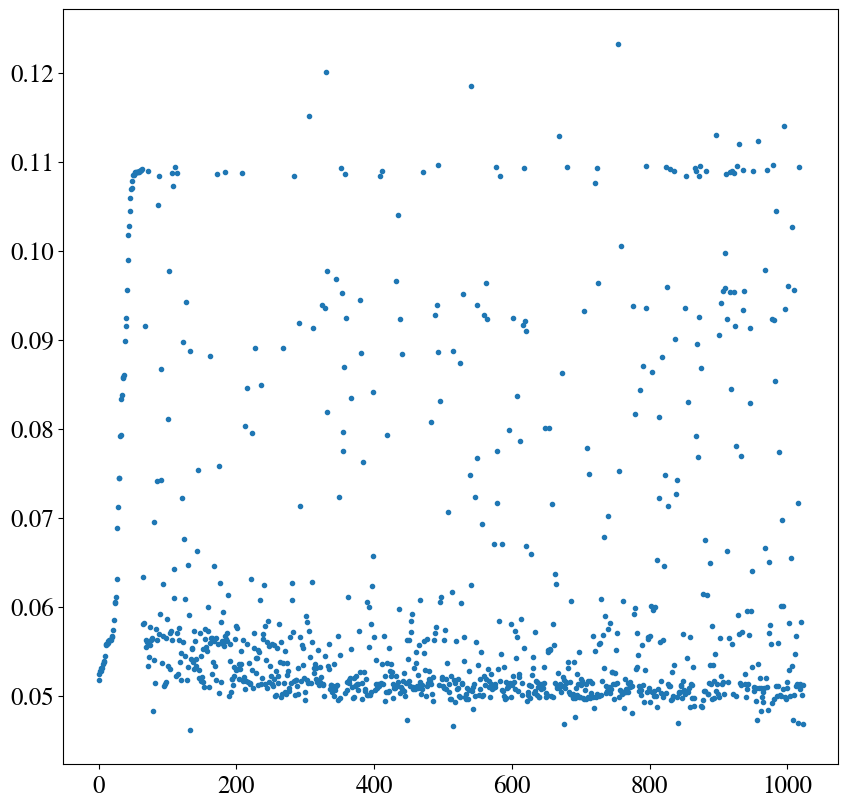

In [38]:
plt.plot(tt, ".")

In [39]:
evolution.dfEvolution()

,K_gl,exc_ext,inh_ext,sigma_ou,score,id,gen,f0
0,5.551922,0.515442,1.570703,0.478246,-0.051778,48,0,0.051778
1,4.816576,0.401176,0.065719,0.464835,-0.052479,24,0,0.052479
2,4.652540,1.394077,3.259866,0.492760,-0.052720,70,0,0.052720
3,1.361481,1.007764,0.884644,0.127342,-0.052786,62,0,0.052786
4,4.098474,1.366792,2.704970,0.439738,-0.053106,88,0,0.053106
...,...,...,...,...,...,...,...,...
1019,5.138878,0.068884,3.105112,0.498620,-0.051327,1083,15,0.051327
1020,2.595044,0.436243,3.684862,0.491748,-0.058308,1084,15,0.058308
1021,3.767785,0.043849,3.579261,0.499653,-0.050078,1085,15,0.050078
1022,1.069573,0.087141,1.004849,0.112266,-0.046764,1086,15,0.046764
